#📌 Extracão

In [ ]:
import pandas as pd
import json
import requests

In [ ]:
response = requests.get('https://raw.githubusercontent.com/sthemonica/alura-voz/main/Dados/Telco-Customer-Churn.json')
dados = response.json()
dados = pd.DataFrame(dados)
display(dados.head())

In [ ]:
customer_data = pd.json_normalize(dados['customer'])
phone_data = pd.json_normalize(dados['phone'])
internet_data = pd.json_normalize(dados['internet'])
account_data = pd.json_normalize(dados['account'])

df = pd.concat([dados.drop(columns=['customer', 'phone', 'internet', 'account']), customer_data, phone_data, internet_data, account_data], axis=1)
display(df.head())

#🔧 Transformação

In [ ]:
df.info()

In [ ]:
for col in df.columns:
  print(f'Valores únicos na coluna {col}: {df[col].nunique()}')
  if df[col].nunique() < 50:
    print(f'{df[col].unique()}')

In [ ]:
print(f'Valores duplicados: {df.duplicated().sum()}')

In [ ]:
print(f'Usuários duplicados: {df[df.duplicated(subset=["customerID"])].shape[0]}')

In [ ]:
print(f'Valores nulos: {df.isnull().sum()}')

In [ ]:
#Vazios ou em branco
df.apply(lambda x: x.astype(str).str.strip() == '').sum()

In [ ]:
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')
#Vazios ou em branco
df.apply(lambda x: x.astype(str).str.strip() == '').sum()

In [ ]:
#Eliminando as linhas em branco em churn
df = df[df['Churn'].astype(str).str.strip() != '']
df.info()

In [ ]:
df = df[df['Charges.Total'].notna()]
df.info()

In [ ]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)
df.head()

In [ ]:
df['ContasDiarias'] = ((df['Charges.Total'] / df['tenure']) / 30).round(2)
df.info()

In [ ]:
bool_Cols = ['Partner', 'Dependents', 'PhoneService',
                'PaperlessBilling', 'Churn', 'SeniorCitizen']

for col in bool_Cols:
  df[col] = df[col].replace({'Yes': 1, 'No': 0, 'Sim': 1, 'Não': 0})
  df[col] = df[col].astype(bool)

df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1})
df['gender'] = df['gender'].astype(bool)

print("Transformação concluída.")


In [ ]:
df.info()

In [ ]:
cols_to_clean = [
    'MultipleLines',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

for col in cols_to_clean:
    if col in df.columns:
        df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

for col in cols_to_clean:
    if col in df.columns:
        df[col] = df[col].replace({'Yes': True, 'No': False})
        if df[col].dtype == 'object':
            df[col] = df[col].astype(bool)

In [ ]:
for col in df.columns:
  print(f'Valores únicos na coluna {col}: {df[col].nunique()}')
  if df[col].nunique() < 50:
    print(f'{df[col].unique()}')

#📊 Carga e análise

In [ ]:
df.describe(include=['O'])

In [ ]:
df.describe()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

churn_counts = df['Churn'].value_counts()

churn_proportions = df['Churn'].value_counts(normalize=True) * 100

print("Contagem de Clientes por Status de Churn:")
print(churn_counts)
print("\nProporção de Clientes por Status de Churn:")
print(churn_proportions)

plt.figure(figsize=(7, 5))
sns.barplot(x=churn_proportions.index, y=churn_proportions.values, palette="viridis")

plt.title('Distribuição de Clientes por Status de Churn', fontsize=16)
plt.xlabel('Churn (Evasão)', fontsize=12)
plt.ylabel('Proporção de Clientes (%)', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Permaneceu (False)', 'Saiu (True)'], fontsize=10)

# Adicionando os valores percentuais nas barras
for index, value in enumerate(churn_proportions.values):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

plt.ylim(0, 100) # Garante que o eixo Y vá até 100%
plt.tight_layout()
plt.show()

##Variáveis categóricas

In [ ]:
def plot_churn_proportions_by_category(df, column_name):
    plt.figure(figsize=(9, 6))
    df_plot = df.groupby(column_name)['Churn'].value_counts(normalize=True).unstack().reset_index()
    df_plot.columns = [column_name, 'No Churn', 'Churn']

    df_plot_melted = df_plot.melt(id_vars=column_name, var_name='Churn_Status', value_name='Proportion')
    df_plot_melted['Proportion'] = df_plot_melted['Proportion'] * 100

    sns.barplot(data=df_plot_melted, x=column_name, y='Proportion', hue='Churn_Status',
                palette={'No Churn': 'skyblue', 'Churn': 'salmon'})

    plt.title(f'Distribuição de Churn por {column_name}', fontsize=16)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Proporção de Clientes (%)', fontsize=12)
    plt.ylim(0, 100)

    for p in plt.gca().patches:
        height = p.get_height()

        if height > 0:
            plt.text(p.get_x() + p.get_width() / 2.,
                     height + 1,
                     f'{height:.1f}%',
                     ha='center', va='bottom', fontsize=9)

    plt.tight_layout() # Ajusta o layout para evitar sobreposição
    plt.legend(title='Churn Status') # Adiciona legenda para as cores
    plt.show()

In [ ]:
categorical_cols_to_analyze = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

print("Gerando gráficos de distribuição de Churn para variáveis categóricas/booleanas:")
for col in categorical_cols_to_analyze:
    plot_churn_proportions_by_category(df, col)

##Varáveis númericas

In [ ]:
import plotly.express as px

In [ ]:
def plot_numerical_churn_histogram_px(df, column_name):
    df_temp = df.copy()
    df_temp['Churn Status'] = df_temp['Churn'].map({True: 'Saiu (Churn)', False: 'Permaneceu (No Churn)'})

    fig = px.histogram(
        df_temp,
        x=column_name,
        color='Churn Status',
        nbins=50,
        title=f'Distribuição de {column_name} por Status de Churn',
        labels={column_name: column_name, 'Churn Status': 'Status de Churn'},
        barmode='group',
        color_discrete_map={'Permaneceu (No Churn)': 'skyblue', 'Saiu (Churn)': 'salmon'}
    )

    fig.update_layout(
        xaxis_title=column_name,
        yaxis_title="Contagem de Clientes",
        font=dict(size=12),
        title_font_size=18,
        legend_title_font_size=14
    )
    fig.show()


In [ ]:

numeric_cols = ['tenure', 'Charges.Monthly', 'Charges.Total', 'ContasDiarias']

for col in numeric_cols:
  plot_numerical_churn_histogram_px(df, col)


In [ ]:
px.scatter(df, x='tenure', y='Charges.Total', color='Churn', title='Relação entre Tenure e Charges.Total')

In [ ]:
px.scatter(df, x='tenure', y='Charges.Monthly', color='Churn', title='Relação entre Tenure e Charges.Month')

In [ ]:
px.box(df, x='Churn', y='Charges.Monthly', title='Distribuição de Charges.Monthly por Churn')

#📄Relatorio Final

## 1. Introdução

Este relatório apresenta a Análise Exploratória de Dados (EDA) realizada para o projeto "Churn de Clientes" da Telecom X. A empresa enfrenta um desafio significativo com a alta taxa de cancelamento de seus serviços, e o objetivo principal desta análise é entender os fatores subjacentes que levam à perda de clientes.

Utilizando a linguagem Python e suas principais bibliotecas (Pandas para manipulação de dados, Matplotlib/Seaborn e Plotly para visualização), o trabalho focou em coletar, limpar, transformar e analisar os dados dos clientes. Os insights obtidos aqui servirão de base para a equipe de Data Science desenvolver modelos preditivos e estratégias de retenção eficazes.

## 2. Limpeza e Tratamento de Dados (ETL)

A fase de Extração, Transformação e Carga (ETL) foi crucial para preparar os dados brutos, garantindo sua qualidade e formato adequado para a análise. Os principais passos realizados foram:

* **Extração:** Os dados foram obtidos de uma API no formato JSON, contendo informações detalhadas sobre clientes, como dados demográficos, serviços contratados e status de evasão.
* **Normalização de Dados Aninhados:** O arquivo JSON possuía estruturas aninhadas (`customer`, `phone`, `internet`, `account`). Essas estruturas foram "achatadas" e transformadas em colunas distintas no DataFrame principal, facilitando a manipulação e análise.
* **Tratamento de Valores Ausentes e Inconsistências:**
    * A coluna `Charges.Total` foi convertida para o tipo numérico. Qualquer valor não numérico (incluindo espaços em branco) foi tratado como ausente e as linhas correspondentes foram removidas, garantindo a integridade dos cálculos.
    * Valores em branco na coluna `Churn` também foram tratados, removendo qualquer linha inconsistente para assegurar a precisão da variável alvo.
* **Padronização de Variáveis Categóricas/Booleanas:**
    * Variáveis com respostas binárias como "Sim"/"Não" ou "Yes"/"No" (`Partner`, `Dependents`, `PhoneService`, `PaperlessBilling`, `Churn`, `SeniorCitizen`, etc.) foram convertidas para o tipo booleano (`True`/`False`), padronizando a representação e otimizando o uso da memória.
    * A coluna `gender`, originalmente com 'Male'/'Female', foi também convertida para booleano para consistência.
    * Valores como 'No internet service' ou 'No phone service' em colunas de serviço (`OnlineSecurity`, `TechSupport`, `MultipleLines`, etc.) foram padronizados para `False` (representando a ausência do serviço), permitindo uma análise mais coesa sobre a presença vs. ausência de serviços.

Ao final deste processo, obtivemos um DataFrame limpo, estruturado e com os tipos de dados corretos, pronto para a Análise Exploratória.

## 3. Análise Exploratória de Dados (EDA)

A Análise Exploratória de Dados focou em identificar padrões, tendências e relações entre as características dos clientes e o status de churn, utilizando visualizações estratégicas.

### 3.1. Taxa de Churn Geral

A análise inicial da variável `Churn` revelou a proporção de clientes que evadiram na Telecom X. 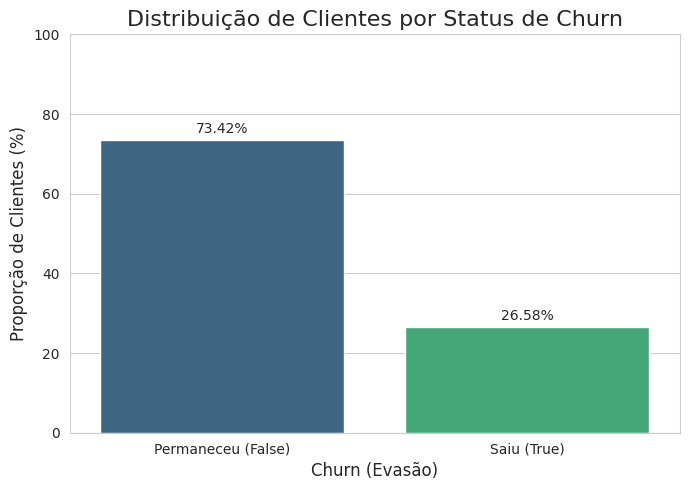

### 3.2. Análise por Variáveis Categóricas

Os gráficos de barras com proporções de churn por categoria (como os que você já me forneceu e analisamos) revelaram insights cruciais:

* **Contract (Tipo de Contrato):**
    * **Insight:** Clientes com **contrato Mês a Mês** (`Month-to-month`) apresentaram uma taxa de churn dramaticamente mais alta (aprox. 42.7%) em comparação com contratos de um ano (aprox. 11.3%) e dois anos (aprox. 2.8%).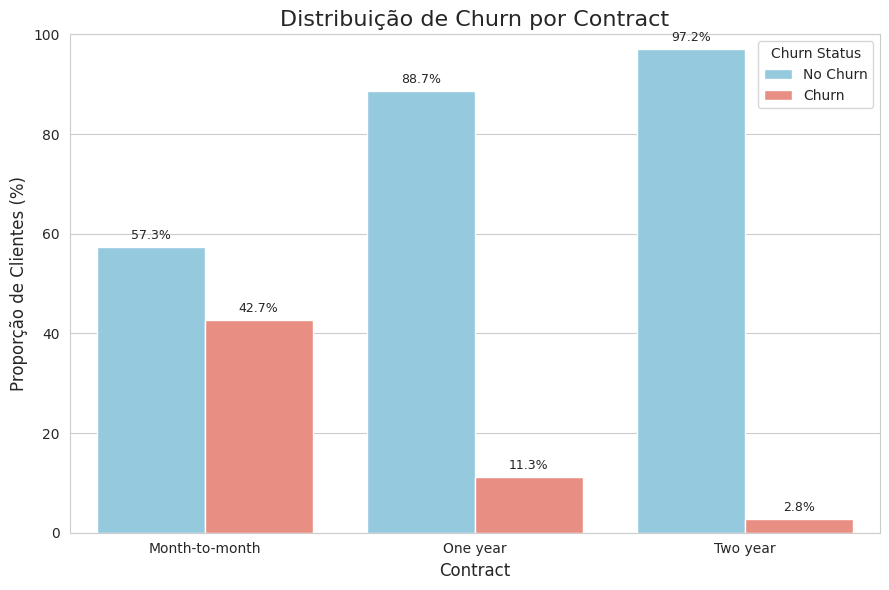

* **PaymentMethod (Método de Pagamento):**
    * **Insight:** O método de pagamento **"Electronic check"** está fortemente associado a uma taxa de churn altíssima (aprox. 45.3%). Outros métodos como `Bank transfer (automatic)` e `Credit card (automatic)` tiveram as menores taxas (aprox. 16.7% e 15.3%, respectivamente).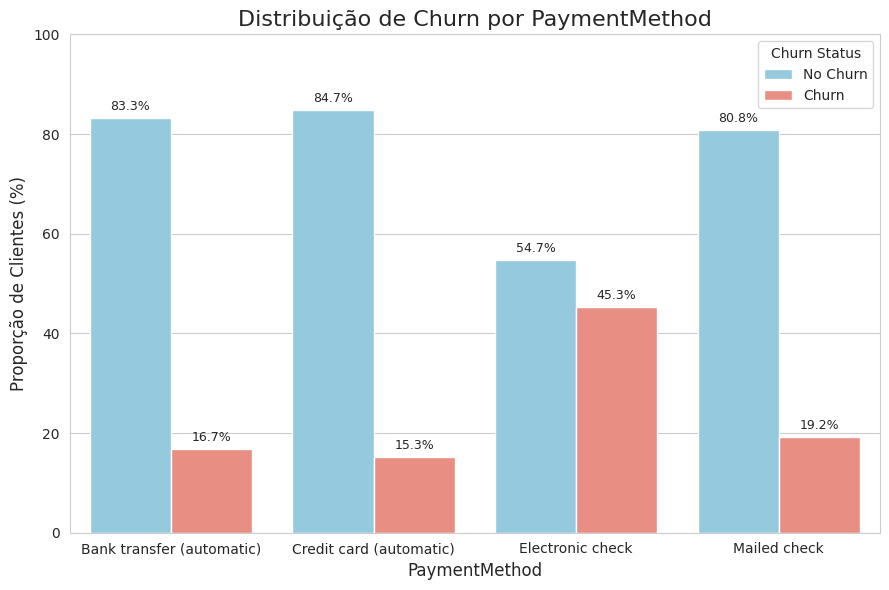

* **InternetService (Serviço de Internet):**
    * **Insight:** Clientes com serviço de **Fibra Óptica** (`Fiber optic`) churnam a uma taxa alarmantemente alta (aprox. 41.9%), mais do que o dobro do DSL (aprox. 19.0%) e muito mais do que clientes sem serviço de internet (aprox. 7.4%).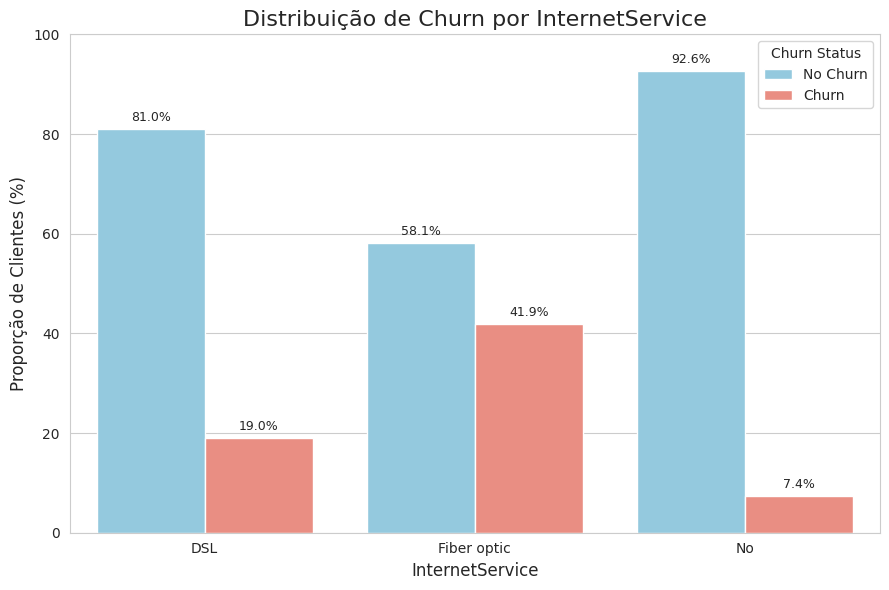

* **OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport (Serviços Agregados):**
    * **Insight:** A **ausência** desses serviços de valor agregado está consistentemente associada a taxas de churn significativamente mais altas. Por exemplo, clientes sem `OnlineSecurity` (aprox. 31.4% de churn) ou sem `TechSupport` (aprox. 31.2% de churn) têm o dobro do risco de churnar em comparação com aqueles que possuem os serviços (aprox. 14.6% e 15.2% respectivamente).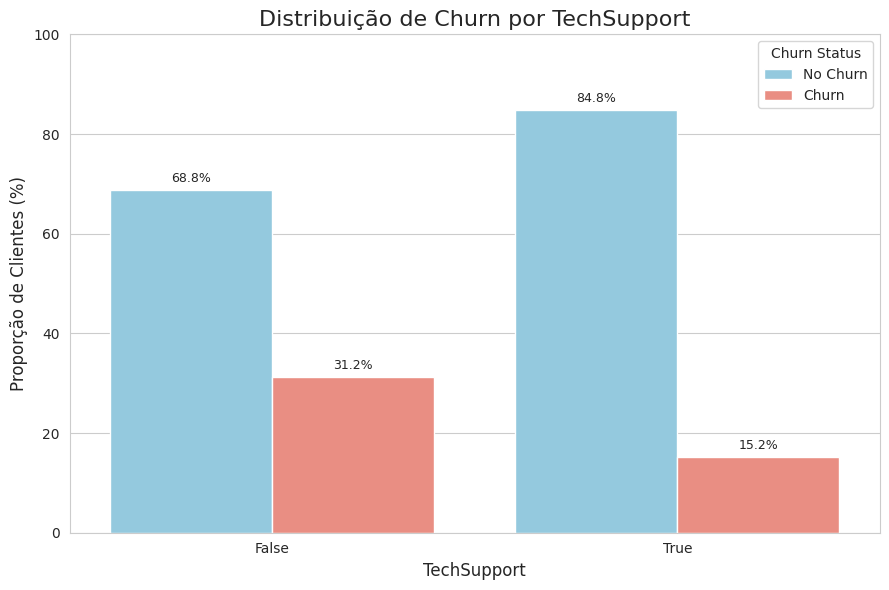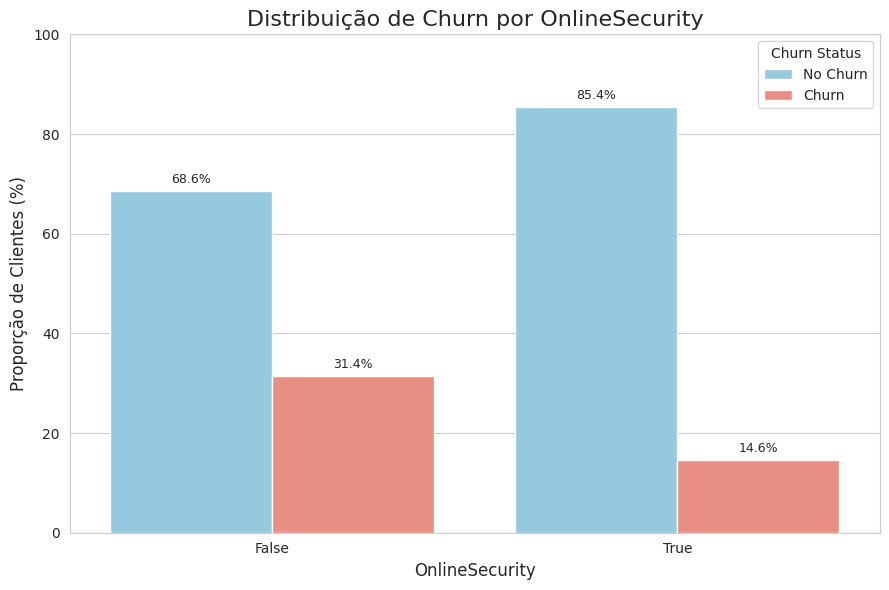

* **SeniorCitizen (Idoso):**
    * **Insight:** Clientes **seniores** (`True`) têm uma taxa de churn significativamente maior (aprox. 41.7%) em comparação com clientes não seniores (aprox. 23.7%).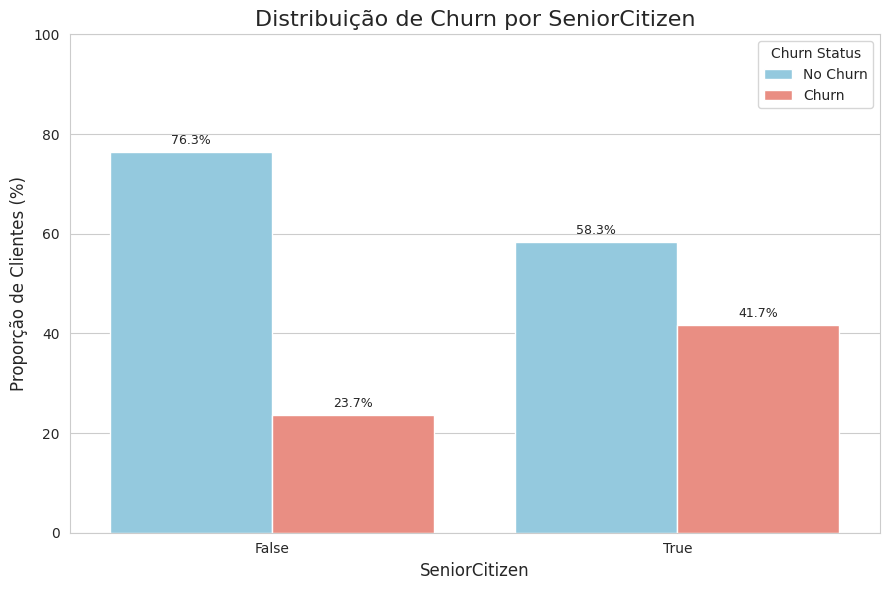

* **Partner e Dependents (Parceiro e Dependentes):**
    * **Insight:** Clientes **sem parceiro** (aprox. 33.0% de churn) e **sem dependentes** (aprox. 31.3% de churn) são mais propensos a churnar do que aqueles que os possuem (aprox. 19.7% e 15.5% respectivamente).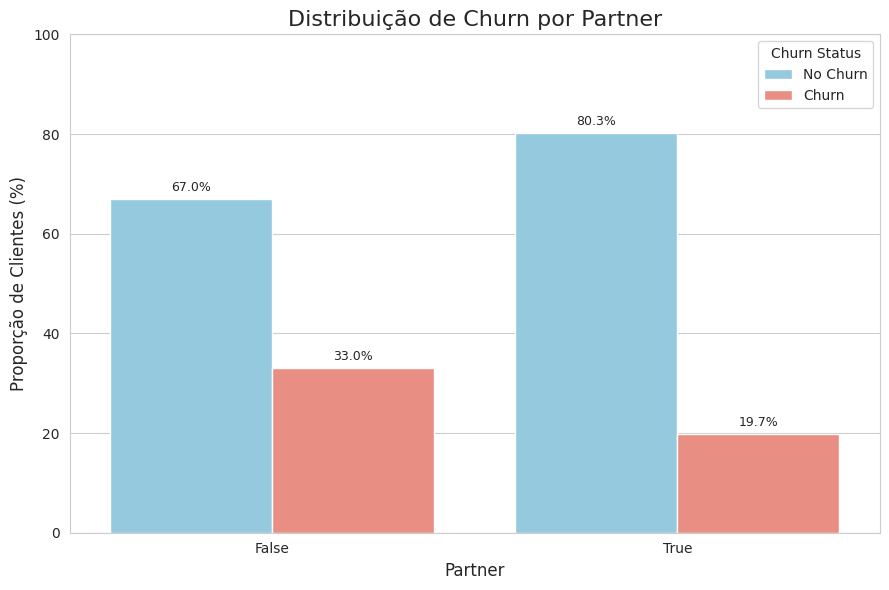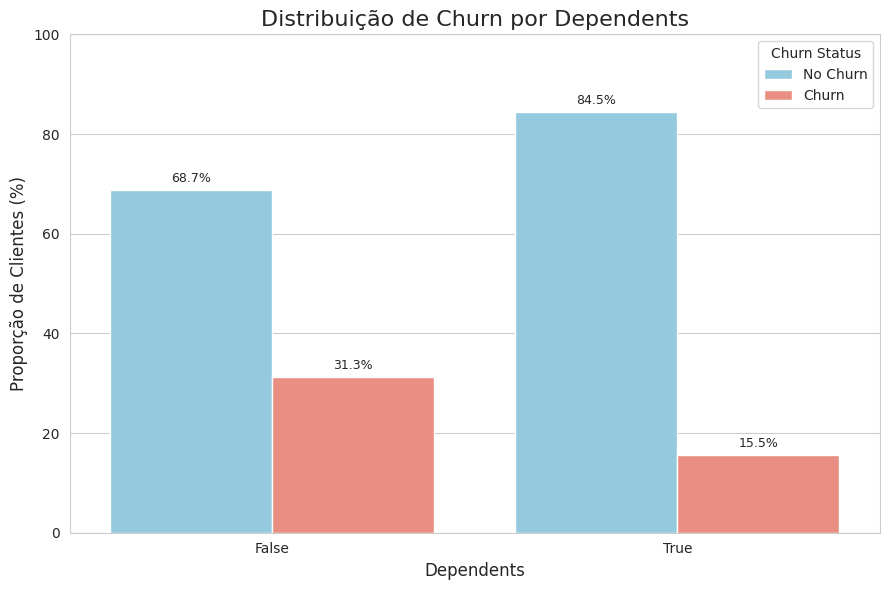

* **PaperlessBilling (Fatura Sem Papel):**
    * **Insight:** Clientes que optam por **fatura sem papel** (`True`) têm uma taxa de churn significativamente maior (aprox. 33.6%) em comparação com aqueles com fatura física (aprox. 16.4%). Este é um insight contraintuitivo.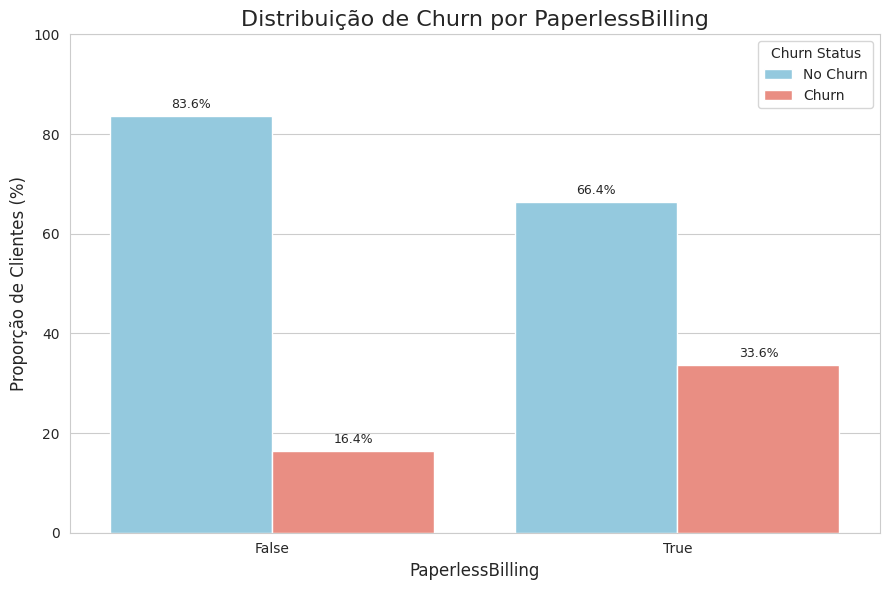

* **Gender, PhoneService, MultipleLines, StreamingTV, StreamingMovies:**
    * **Insight:** Estas variáveis mostraram **pouca ou nenhuma diferença significativa** na taxa de churn entre suas categorias.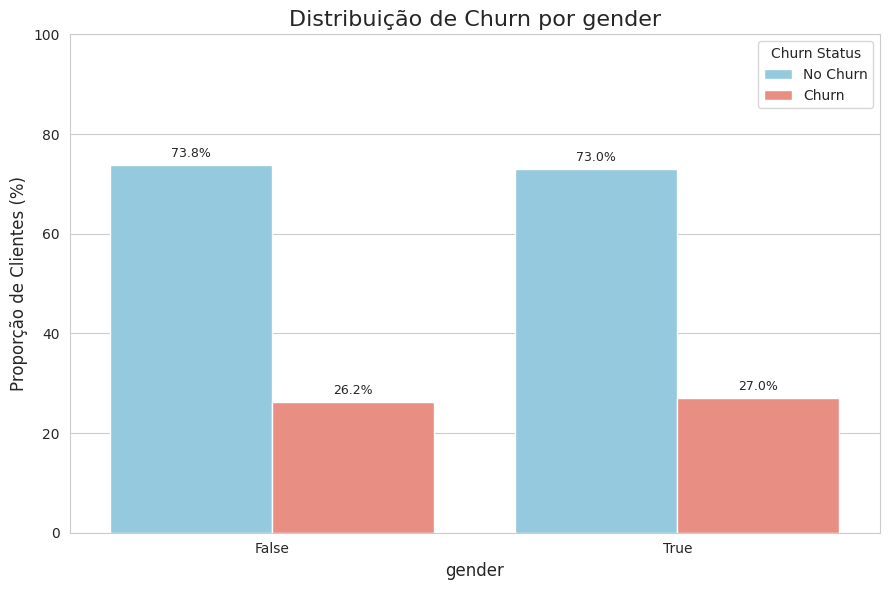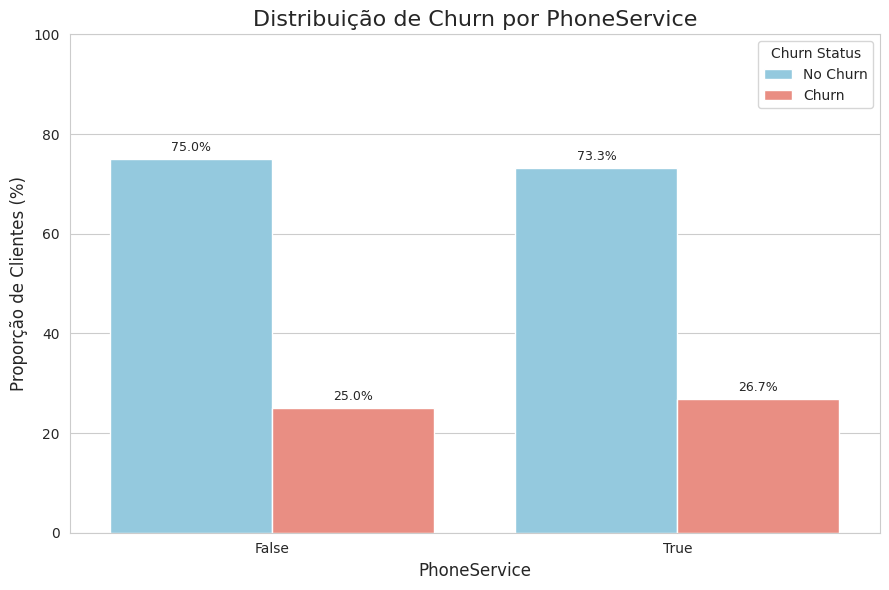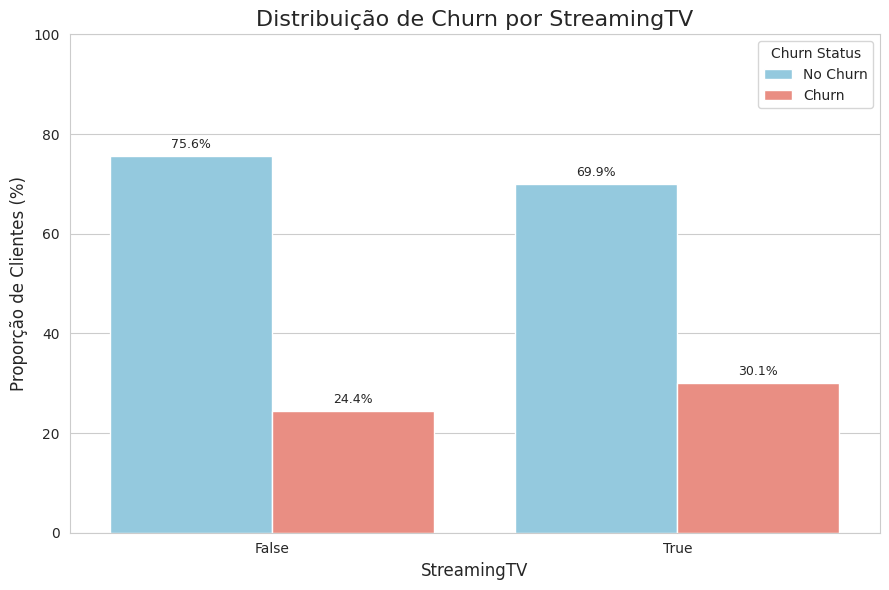

### 3.3. Análise por Variáveis Numéricas

Os histogramas interativos gerados com Plotly Express forneceram insights sobre a distribuição das variáveis numéricas em relação ao churn:

* **tenure (Tempo de Cliente em Meses):**
    * **Insight:** Há uma forte concentração de churn para clientes com **baixo `tenure`** (especialmente nos primeiros 6-12 meses). A taxa de churn diminui drasticamente para clientes de longa data.
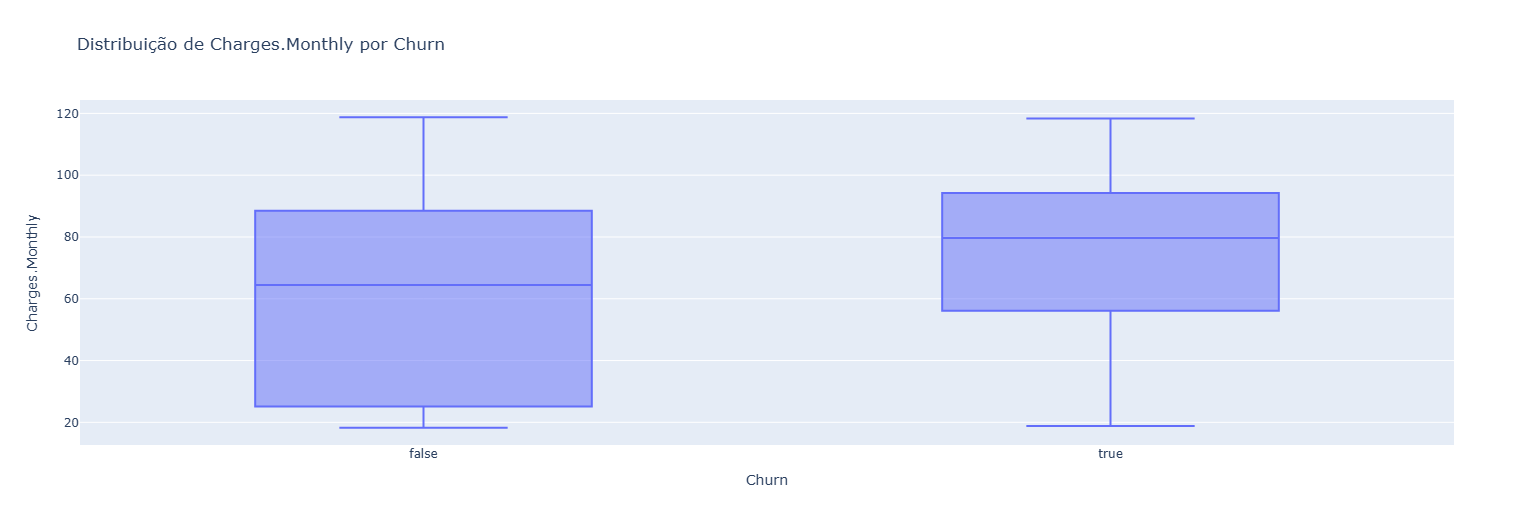
* **Charges.Monthly (Cobranças Mensais):**
    * **Insight:** Clientes que churnam mostram uma distribuição com maior concentração na faixa de **cobranças mensais médias a altas** (acima de $70), enquanto clientes que permanecem têm picos tanto em cobranças baixas quanto altas. Isso sugere que a insatisfação é maior para quem paga mais.
    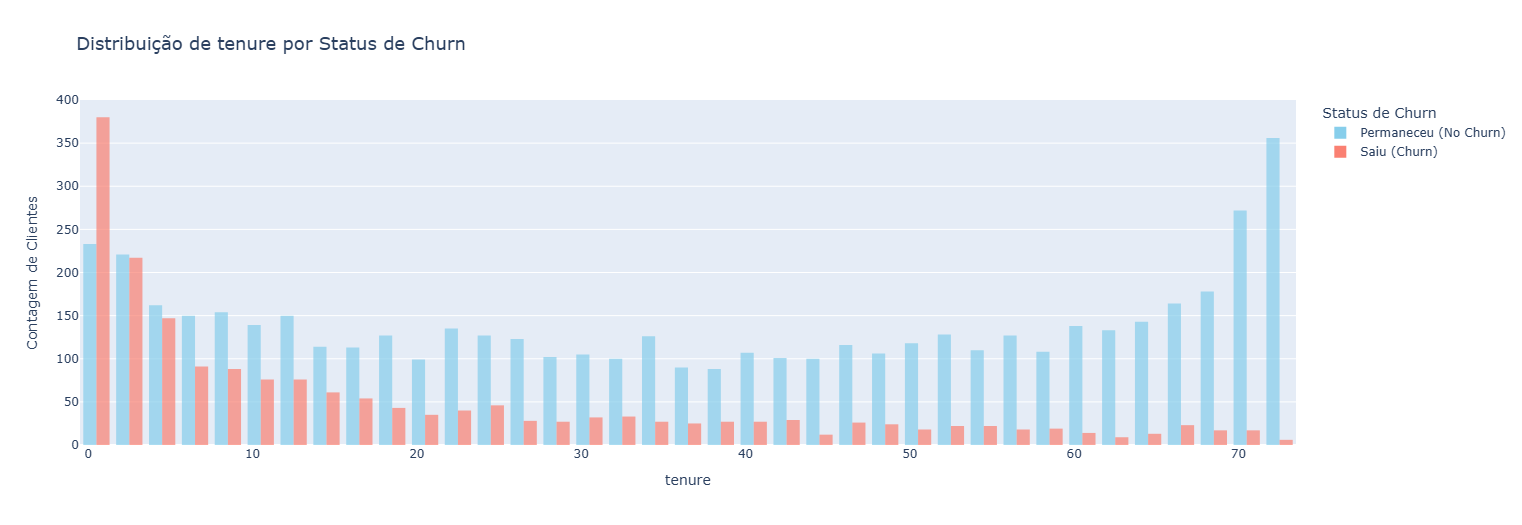

* **Charges.Total (Cobranças Totais Acumuladas):**
    * **Insight:** Este gráfico reforça o achado de `tenure`. Clientes que churnam têm **baixas `Charges.Total`**, indicando que são clientes mais novos que não acumularam muitas cobranças antes de evadir.
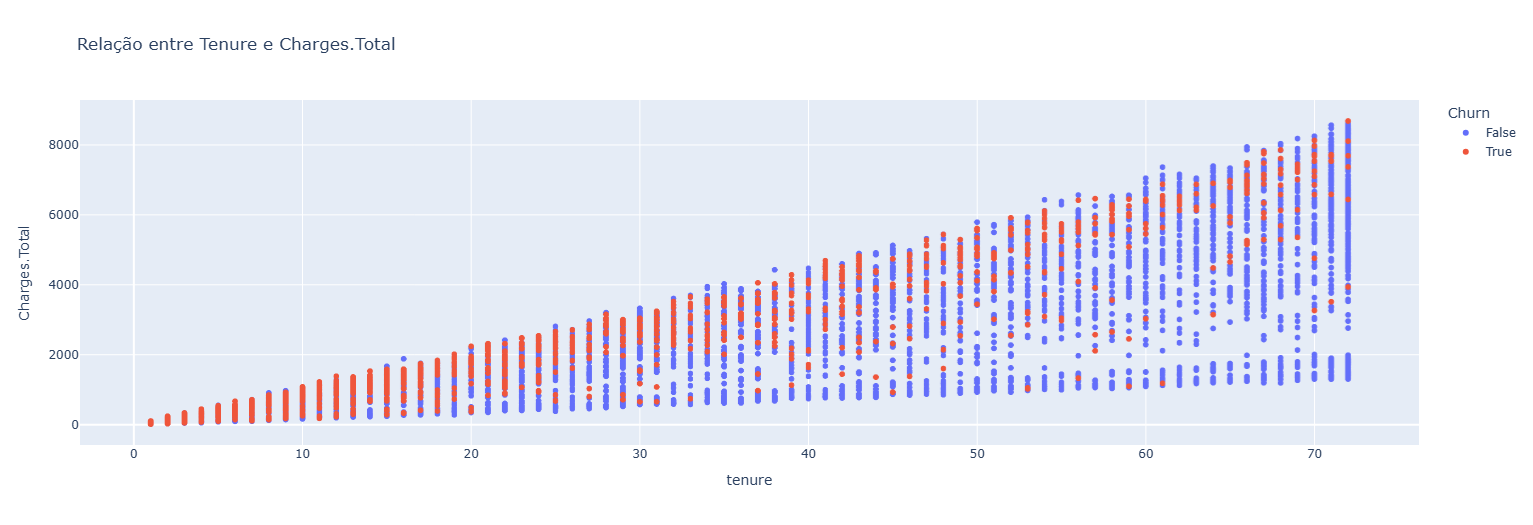

* **ContasDiarias:**
    * **Insight:** A distribuição de `ContasDiarias` para clientes que churnam e não churnam é bastante semelhante, sugerindo que esta variável **não é um forte preditor** de churn por si só.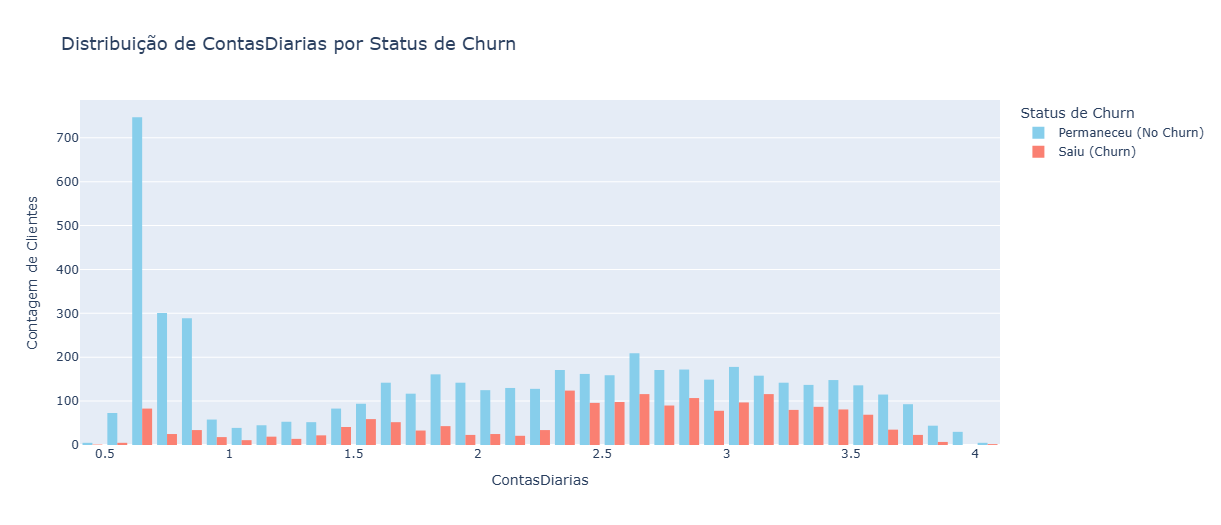
      
## 4. Conclusões e Insights Principais

A Análise Exploratória de Dados revelou diversos fatores-chave que influenciam o churn na Telecom X:

1.  **Vulnerabilidade de Clientes Novos e de Contrato Curto:** Os primeiros meses de serviço e o tipo de contrato (mês a mês) são os maiores preditores de churn. Clientes recém-chegados e com menor compromisso contratual são os mais propensos a sair.
2.  **Problemas com Serviços Premium e Custos Elevados:** A alta taxa de churn entre clientes de Fibra Óptica e aqueles com altas cobranças mensais indica possíveis problemas de qualidade, valor percebido ou expectativas não atendidas para os serviços mais caros.
3.  **Impacto do Método de Pagamento:** O uso de "Cheque Eletrônico" como método de pagamento está fortemente correlacionado com o churn, sugerindo fragilidades nesse processo ou um perfil de cliente de maior risco.
4.  **Importância dos Serviços Agregados:** Clientes que optam por serviços como Segurança Online, Suporte Técnico, Backup Online e Proteção de Dispositivo demonstram maior lealdade. A ausência desses serviços aumenta significativamente o risco de churn.
5.  **Perfis Demográficos de Risco:** Clientes seniores, sem parceiro e sem dependentes apresentam maior propensão a churnar.
6.  **Fatura Sem Papel (Paradoxo):** Curiosamente, clientes com fatura sem papel churnam mais, o que pode indicar que são mais ativos digitalmente e, talvez, mais expostos à concorrência ou mais exigentes com a experiência digital.

## 5. Recomendações

Com base nos insights da EDA, as seguintes recomendações são propostas para a Telecom X, visando a redução da evasão de clientes:

1.  **Foco na Retenção de Clientes Novos:**
    * Implementar programas de "boas-vindas" robustos e proativos nos primeiros 3-6 meses de contrato, com acompanhamento de satisfação e resolução rápida de problemas.
    * Oferecer incentivos para que clientes "Mês a Mês" migrem para contratos de maior duração, como descontos ou bônus por fidelidade.
2.  **Investigar e Melhorar a Experiência da Fibra Óptica:**
    * Realizar pesquisas de satisfação e identificar pontos de dor específicos para clientes de Fibra Óptica.
    * Melhorar a qualidade do serviço, suporte técnico ou comunicação de valor para justificar as cobranças mensais mais altas.
    * Avaliar a estratégia de preços da Fibra Óptica em comparação com a concorrência.
3.  **Analisar o Método de Pagamento "Electronic Check":**
    * Investigar se há problemas técnicos ou de usabilidade com o pagamento via cheque eletrônico.
    * Considerar incentivos para que clientes migrem para métodos de pagamento automáticos (cartão de crédito, débito em conta), que demonstraram maior estabilidade.
4.  **Promover Serviços de Valor Agregado:**
    * Aumentar a conscientização e incentivar a adesão a serviços como Segurança Online, Suporte Técnico e Backup/Proteção de Dispositivo, destacando seus benefícios na retenção.
    * Considerar pacotes que já incluam esses serviços para aumentar a "aderência" do cliente à empresa.
5.  **Estratégias para Perfis de Alto Risco:**
    * Desenvolver campanhas de marketing e ofertas direcionadas a clientes seniores, solteiros e sem dependentes, visando entender suas necessidades e aumentar a lealdade.
6.  **Reavaliar a Fatura Sem Papel:**
    * Investigar o motivo pelo qual clientes com fatura sem papel churnam mais. Pode ser que a comunicação digital precise ser otimizada, ou que esses clientes sejam mais sensíveis a ofertas de concorrentes online.

Esses insights e recomendações fornecem uma base sólida para a próxima fase do projeto, onde modelos preditivos poderão ser desenvolvidos para identificar clientes em risco de churn com maior precisão e permitir intervenções proativas da Telecom X.

---